In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


This dataset covers Apple's stock price until 2023. I will use Facebook Prophet for predictions. The goal is to extract insights and provide clear, actionable information for informed decision-making.

Columns :

Open: This is the price at which the stock first started trading during a trading session

Close: This is the price at which the stock finished trading at the end of a trading session.

High: This is the highest price the stock reached during the trading session

Low: This is the lowest price the stock reached during the trading session

Volume: This represents the total number of shares of the stock that were traded during the session

Adj Close (Adjusted Close): This is the closing price adjusted for any corporate actions like stock splits or dividends

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import plotly.graph_objects as go
import plotly.express as px
import missingno as msno

import warnings
warnings.filterwarnings("ignore")

plt.style.use("seaborn-whitegrid")

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/dataset/apple_stock.csv')

In [ ]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-01-02,19.845715,19.893929,19.715000,19.754642,17.318729,234684800
1,2014-01-03,19.745001,19.775000,19.301071,19.320715,16.938305,392467600
2,2014-01-06,19.194643,19.528570,19.057142,19.426071,17.030676,412610800
3,2014-01-07,19.440001,19.498571,19.211430,19.287144,16.908880,317209200
4,2014-01-08,19.243214,19.484285,19.238930,19.409286,17.015959,258529600


In [ ]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2475.000000,2475.000000,2475.000000,2475.000000,2475.000000,2.475000e+03
mean,76.004968,76.845661,75.213720,76.064199,74.097124,1.380565e+08
std,54.739063,55.389713,54.134658,54.787600,55.248195,8.399674e+07
min,17.684999,17.911785,17.626785,17.849285,15.648315,3.145820e+07
25%,29.592500,29.841249,29.371249,29.707500,27.131330,8.300500e+07
50%,47.507500,47.967499,47.267502,47.599998,45.507229,1.134760e+08
75%,132.145004,133.680000,130.495003,132.029999,130.403320,1.682138e+08
max,196.240005,198.229996,195.279999,196.449997,195.926956,1.065523e+09


<Axes: >

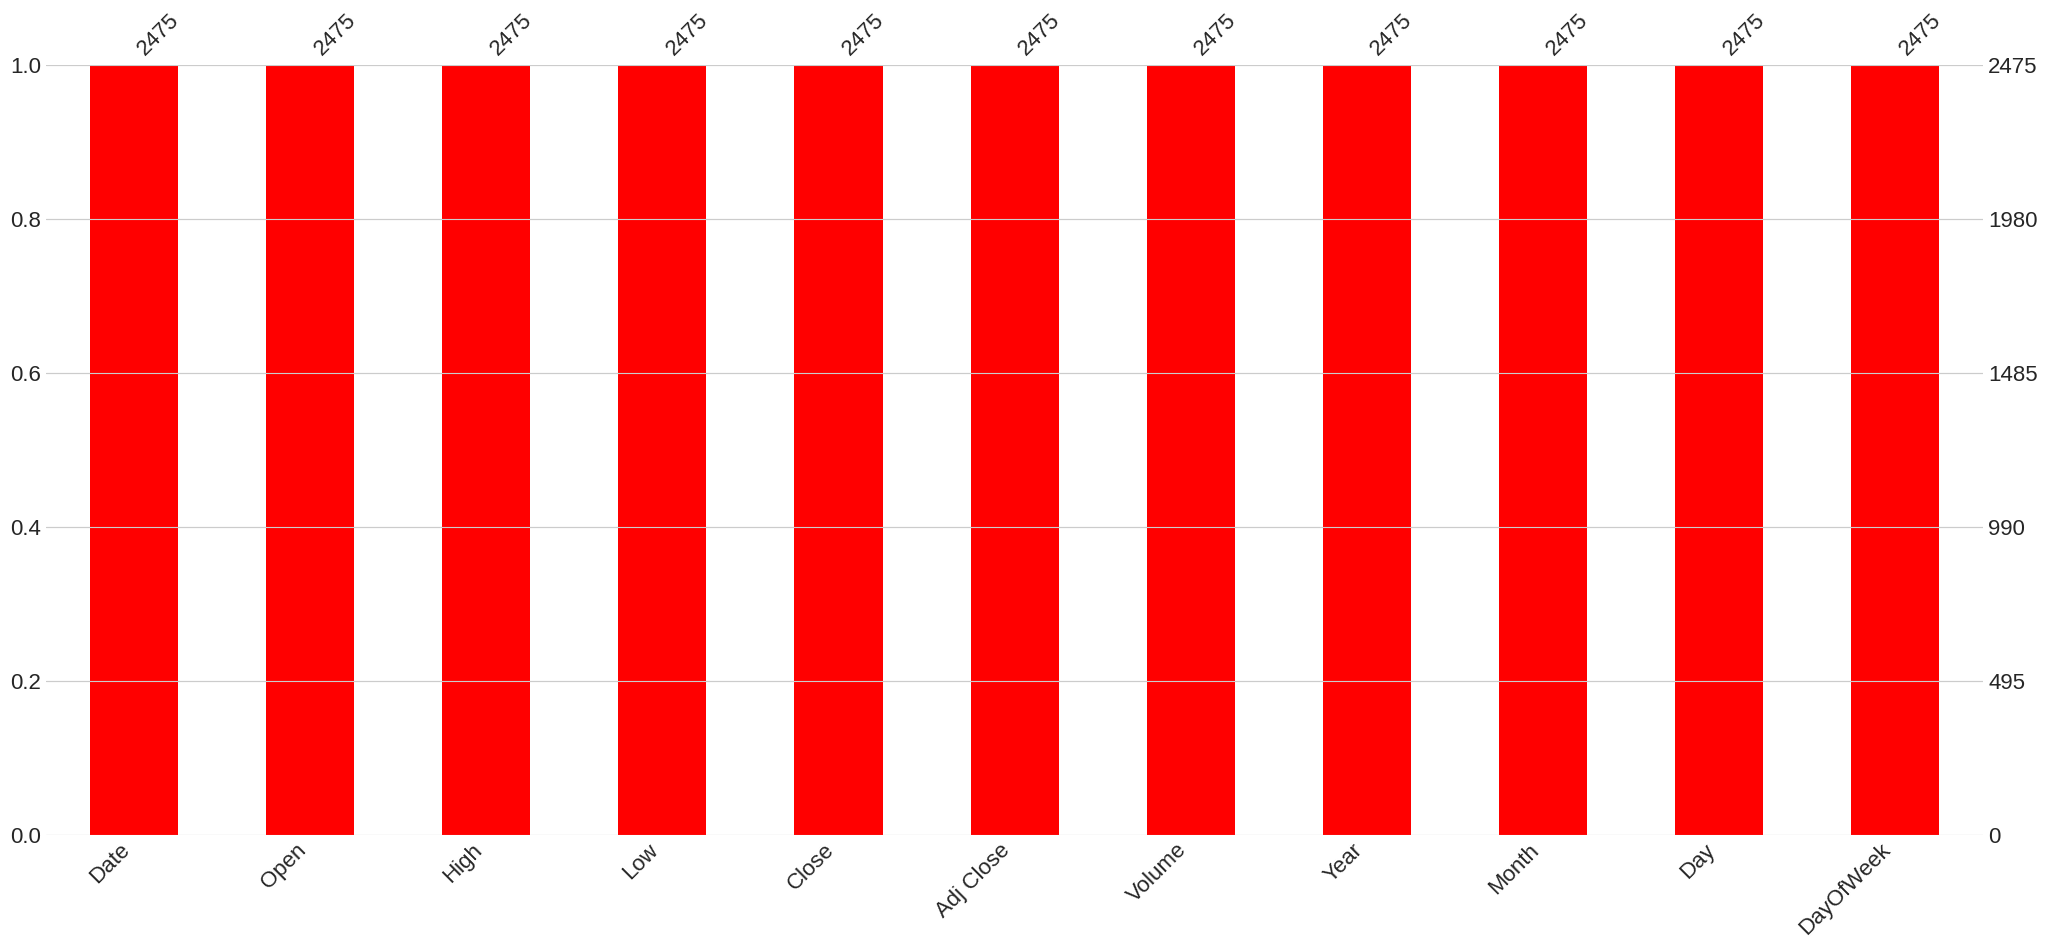

In [ ]:
msno.bar(df, color = 'r')

In [ ]:
  df.duplicated().sum()

0

EDA

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])

df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['DayOfWeek'] = df['Date'].dt.day_name()

In [ ]:
print(f"Min date from df: {df['Date'].min().date()}")
print(f"Max date from df: {df['Date'].max().date()}")

Min date from df: 2014-01-02
Max date from df: 2023-10-31


Visualisation

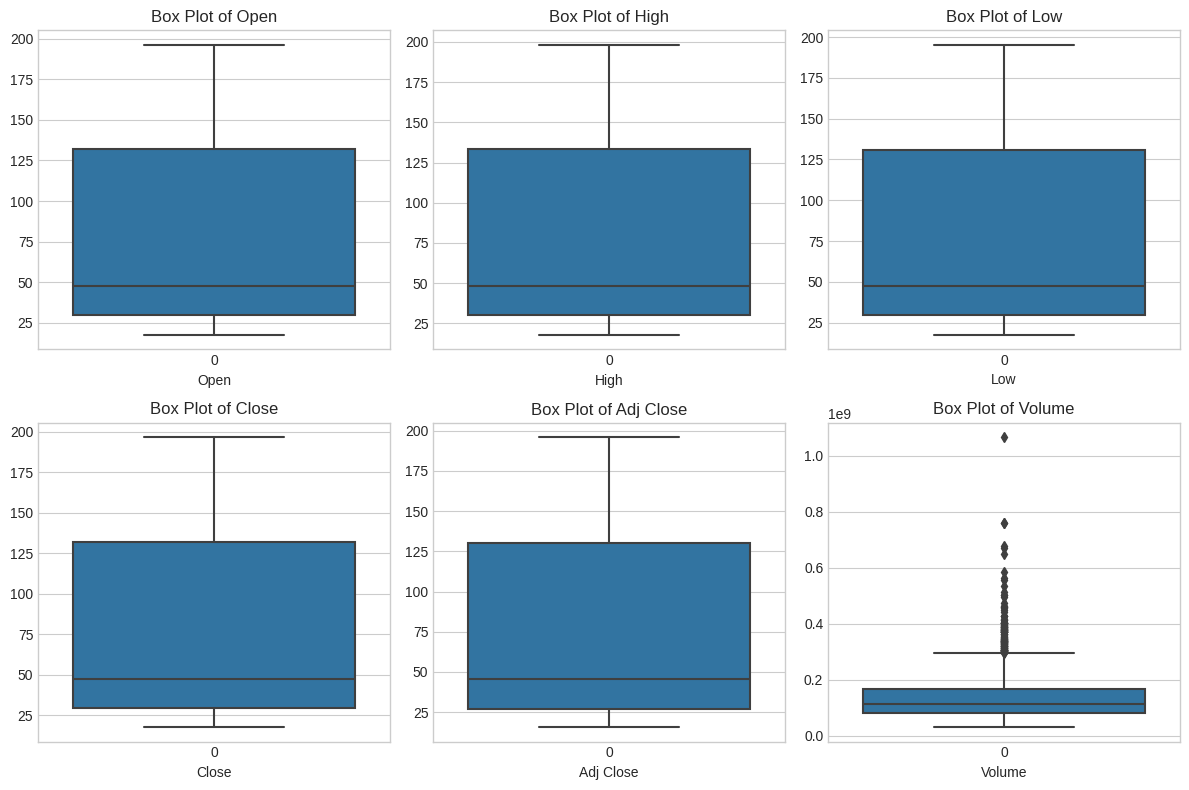

In [ ]:
columns_for_boxplot =['Open', 'High', 'Low', 'Close','Adj Close','Volume']

# Create subplots for each column
plt.figure(figsize=(12, 8))
for i, col in enumerate(columns_for_boxplot, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(df[col])
    plt.title(f'Box Plot of {col}')
    plt.xlabel(col)

plt.tight_layout()
plt.show()

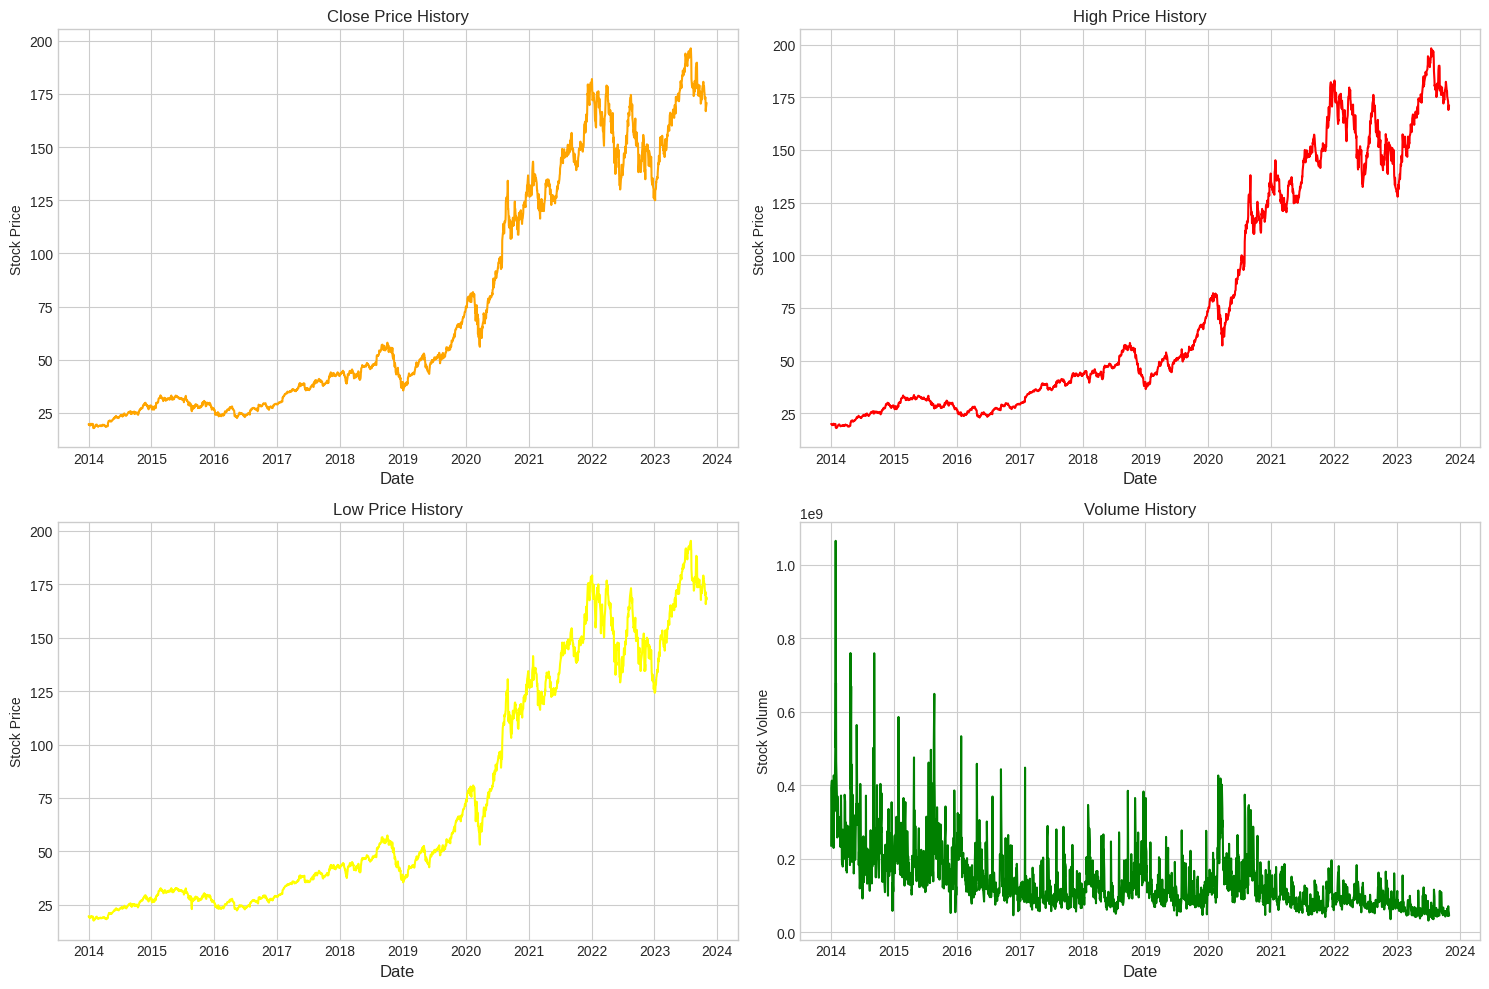

In [ ]:
f, axes = plt.subplots(2, 2, figsize=(15, 10))

# First Subplot - Close Price History
axes[0, 0].plot(df['Date'], df['Close'],color='orange')
axes[0, 0].set_xlabel("Date", fontsize=12)
axes[0, 0].set_ylabel("Stock Price")
axes[0, 0].set_title("Close Price History")

# Second Subplot - High Price History
axes[0, 1].plot(df['Date'], df['High'], color="red")
axes[0, 1].set_xlabel("Date", fontsize=12)
axes[0, 1].set_ylabel("Stock Price")
axes[0, 1].set_title("High Price History")

# Third Subplot - Low Price History
axes[1, 0].plot(df['Date'], df['Low'], color="yellow")
axes[1, 0].set_xlabel("Date", fontsize=12)
axes[1, 0].set_ylabel("Stock Price")
axes[1, 0].set_title("Low Price History")

# Fourth Subplot - Volume History
axes[1, 1].plot(df['Date'], df['Volume'], color="green")
axes[1, 1].set_xlabel("Date", fontsize=12)
axes[1, 1].set_ylabel("Stock Volume")
axes[1, 1].set_title("Volume History")

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

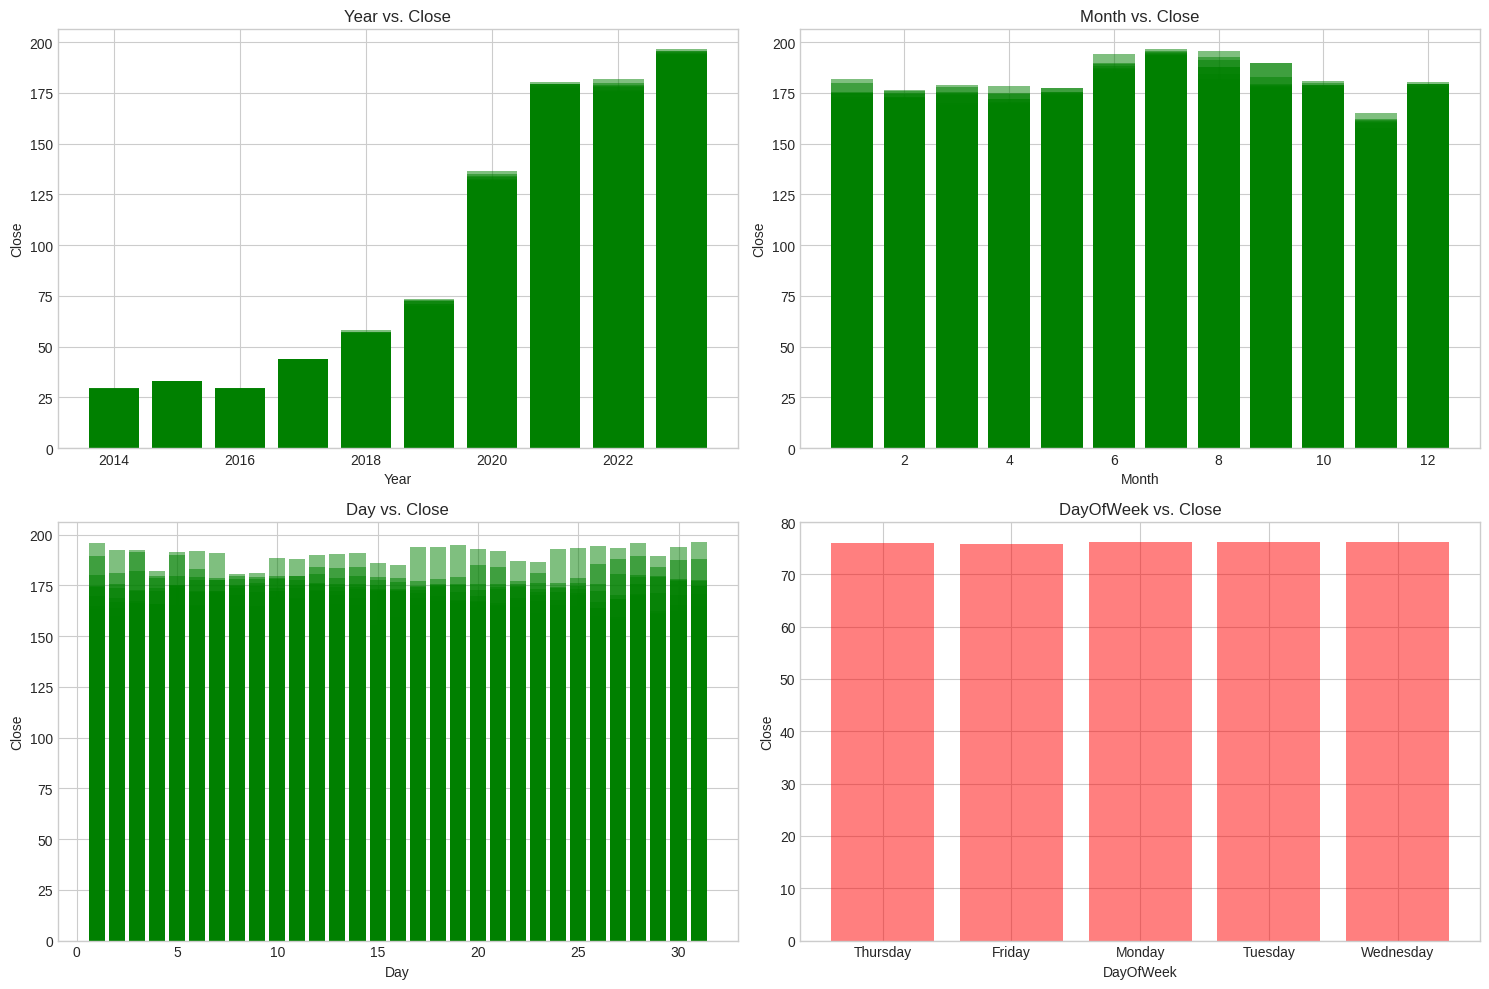

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
variables = ['Year', 'Month', 'Day', 'DayOfWeek']
titles = ['Year vs. Close', 'Month vs. Close', 'Day vs. Close', 'DayOfWeek vs. Close']

for i, ax in enumerate(axs.flat):
    if variables[i] == 'DayOfWeek':
        ax.bar(df[variables[i]].unique(), df.groupby(variables[i])['Close'].mean(), alpha=0.5, color = 'red')
    else:
        ax.bar(df[variables[i]], df['Close'], alpha=0.5, color = 'green')

    ax.set_title(titles[i])
    ax.set_xlabel(variables[i])
    ax.set_ylabel('Close')
    ax.grid(True)

plt.tight_layout()
plt.show()

modeling

In [ ]:
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from prophet.plot import plot, plot_components
from prophet.plot import plot_cross_validation_metric
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
df = pd.DataFrame({
    'ds': df['Date'],
    'y': df['Close']
})

In [ ]:
model = Prophet()

In [ ]:
model.fit(df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5ist70jx/216l7s8u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5ist70jx/j8wvkgoi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6802', 'data', 'file=/tmp/tmp5ist70jx/216l7s8u.json', 'init=/tmp/tmp5ist70jx/j8wvkgoi.json', 'output', 'file=/tmp/tmp5ist70jx/prophet_modele5jblyud/prophet_model-20240107164645.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:46:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:46:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prediction Next Year

In [ ]:
future = model.make_future_dataframe(periods=364)

In [ ]:
forecast = model.predict(future)

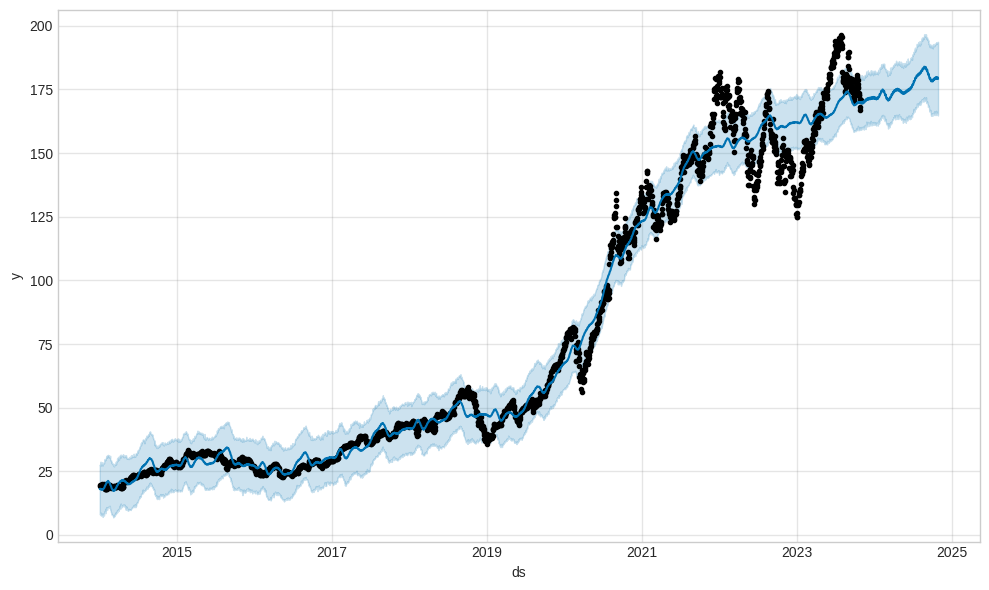

In [ ]:
fig = model.plot(forecast)

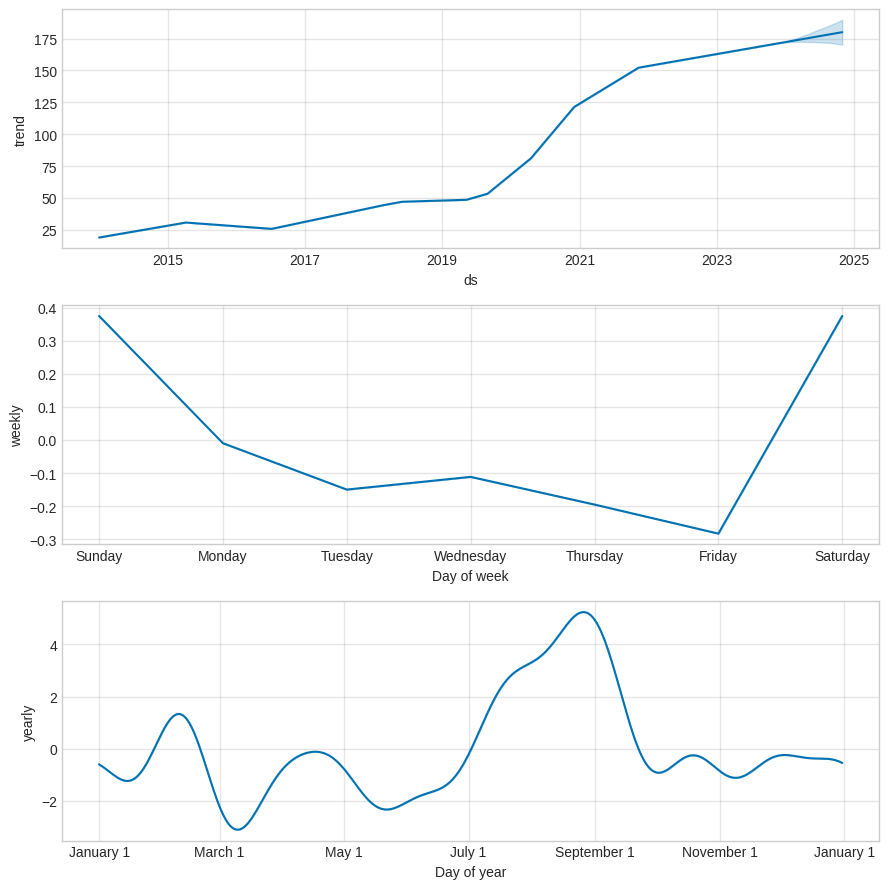

In [ ]:
fig_comp = model.plot_components(forecast)

Trend Changepoints

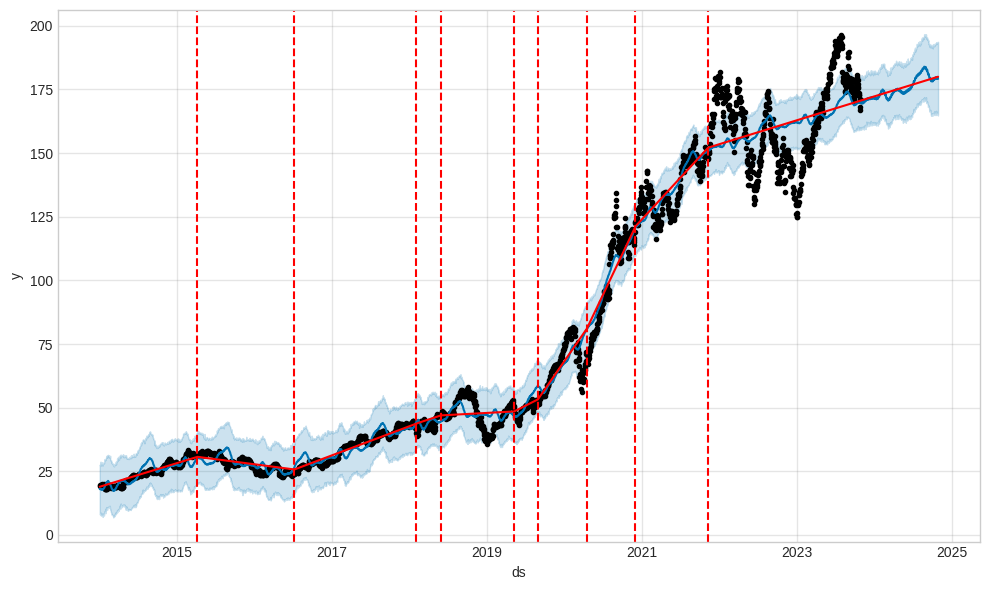

In [ ]:
fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)

In [ ]:
model.changepoints

79     2014-04-28
158    2014-08-19
237    2014-12-10
317    2015-04-08
396    2015-07-30
475    2015-11-19
554    2016-03-16
633    2016-07-08
712    2016-10-28
792    2017-02-24
871    2017-06-19
950    2017-10-10
1029   2018-02-02
1108   2018-05-29
1187   2018-09-19
1267   2019-01-15
1346   2019-05-09
1425   2019-08-30
1504   2019-12-23
1583   2020-04-17
1662   2020-08-10
1742   2020-12-02
1821   2021-03-29
1900   2021-07-21
1979   2021-11-10
Name: ds, dtype: datetime64[ns]

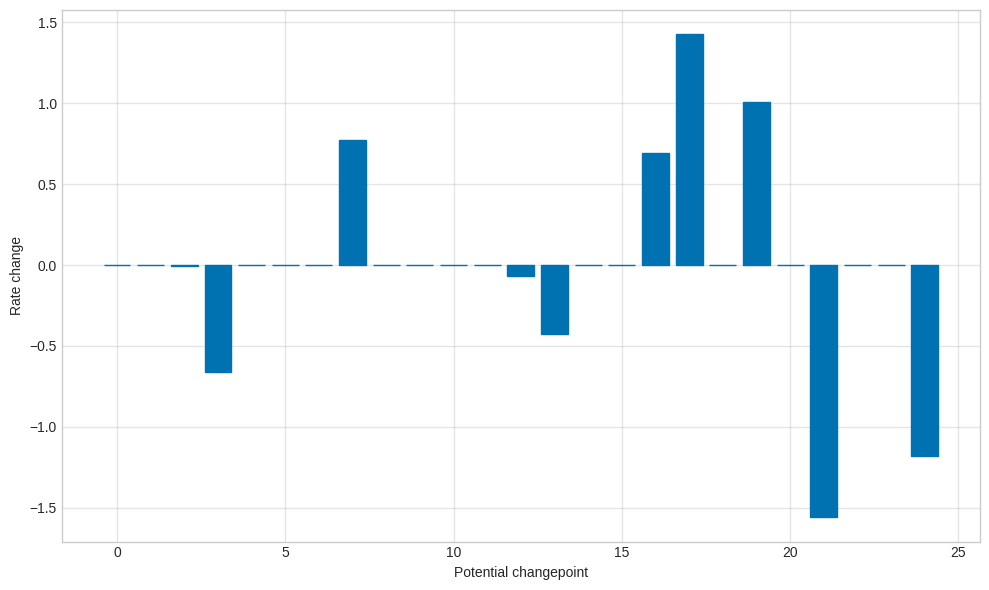

In [ ]:
deltas = model.params['delta'].mean(0)
fig = plt.figure(facecolor='w', figsize=(10, 6))
ax = fig.add_subplot(111)
ax.bar(range(len(deltas)), deltas, facecolor='#0072B2', edgecolor='#0072B2')
ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
ax.set_ylabel('Rate change')
ax.set_xlabel('Potential changepoint')
fig.tight_layout()

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5ist70jx/y237nfxq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5ist70jx/9_se44lp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40072', 'data', 'file=/tmp/tmp5ist70jx/y237nfxq.json', 'init=/tmp/tmp5ist70jx/9_se44lp.json', 'output', 'file=/tmp/tmp5ist70jx/prophet_modellgs77ldv/prophet_model-20240107164848.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:48:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:48:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


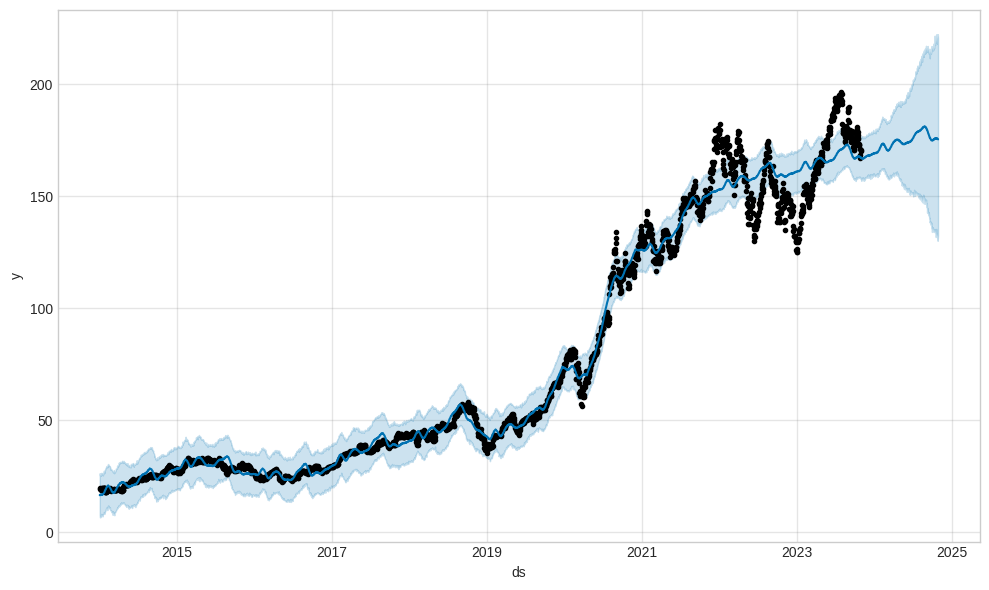

In [ ]:
m = Prophet(changepoint_prior_scale=0.5)
forecast = m.fit(df).predict(future)
fig = m.plot(forecast)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5ist70jx/m7rf1ufn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5ist70jx/34ae5m3y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79324', 'data', 'file=/tmp/tmp5ist70jx/m7rf1ufn.json', 'init=/tmp/tmp5ist70jx/34ae5m3y.json', 'output', 'file=/tmp/tmp5ist70jx/prophet_model7lj4o61t/prophet_model-20240107164906.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:49:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:49:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


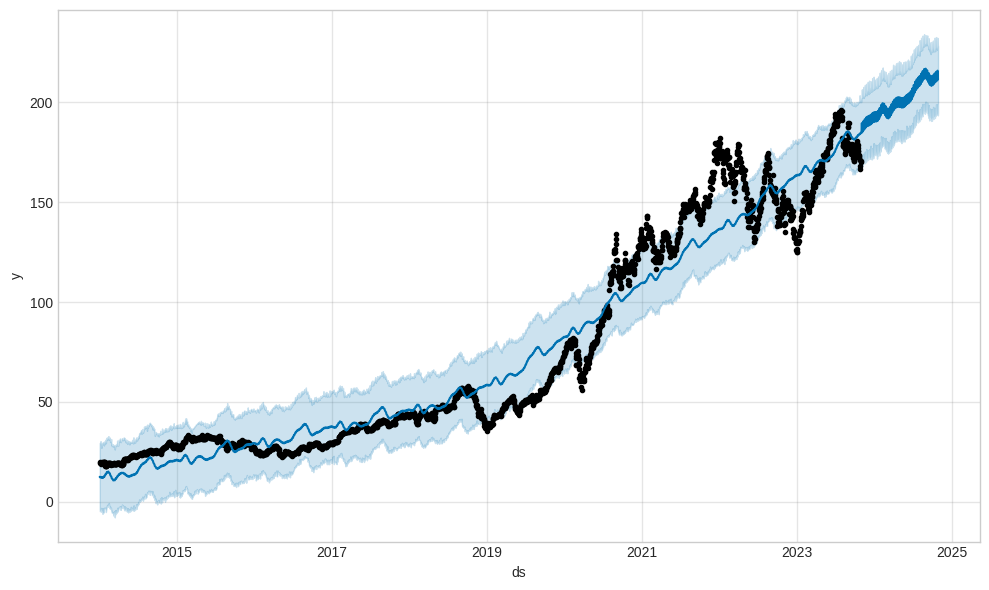

In [ ]:
m = Prophet(changepoint_prior_scale=0.001)
forecast = m.fit(df).predict(future)
fig = m.plot(forecast)

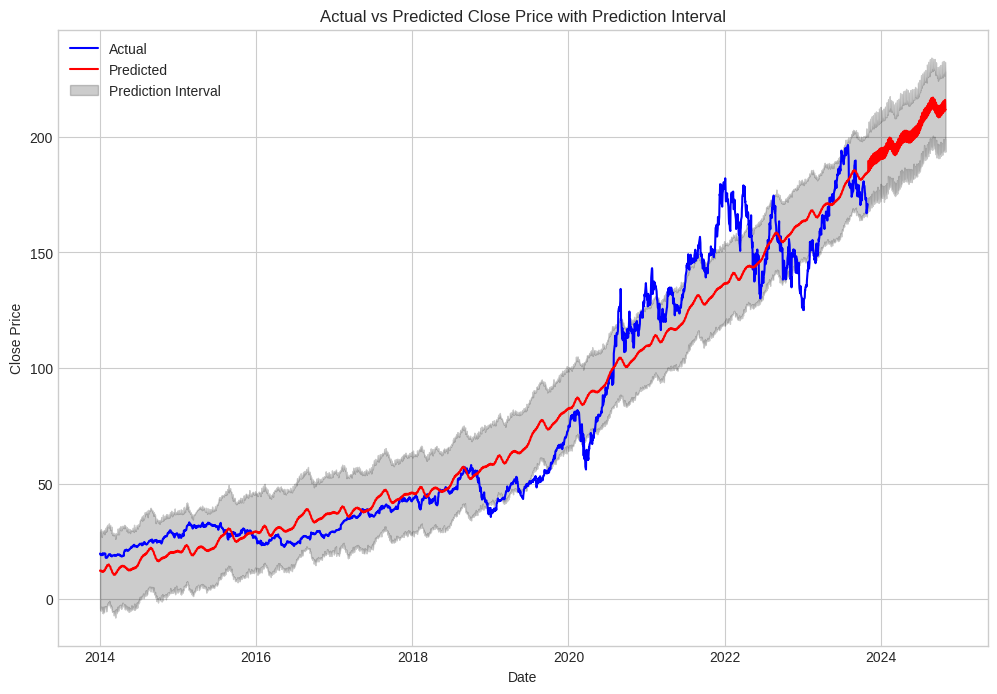

In [ ]:
plt.figure(figsize=(12, 8))  # Set figure size here
plt.plot(df['ds'], df['y'], label='Actual', color='blue')

plt.plot(forecast['ds'], forecast['yhat'], label='Predicted', color='red')

plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='black', alpha=0.2, label='Prediction Interval')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Actual vs Predicted Close Price with Prediction Interval')
plt.legend()

plt.show()

Modeling Holidays

In [ ]:
m = Prophet(seasonality_mode='multiplicative', yearly_seasonality=2)
m.add_country_holidays(country_name='US')
m.fit(df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5ist70jx/5uwfoc3f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5ist70jx/w4au1bby.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77156', 'data', 'file=/tmp/tmp5ist70jx/5uwfoc3f.json', 'init=/tmp/tmp5ist70jx/w4au1bby.json', 'output', 'file=/tmp/tmp5ist70jx/prophet_modelnezjsyj4/prophet_model-20240107164956.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:49:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:50:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
m.train_holiday_names

0                          Martin Luther King Jr. Day
1                               Washington's Birthday
2                                        Columbus Day
3                                      New Year's Day
4                                        Memorial Day
5                                    Independence Day
6                                           Labor Day
7                                        Veterans Day
8                                        Thanksgiving
9                                       Christmas Day
10                           Christmas Day (Observed)
11                          New Year's Day (Observed)
12                            Veterans Day (Observed)
13                        Independence Day (Observed)
14               Juneteenth National Independence Day
15    Juneteenth National Independence Day (Observed)
dtype: object

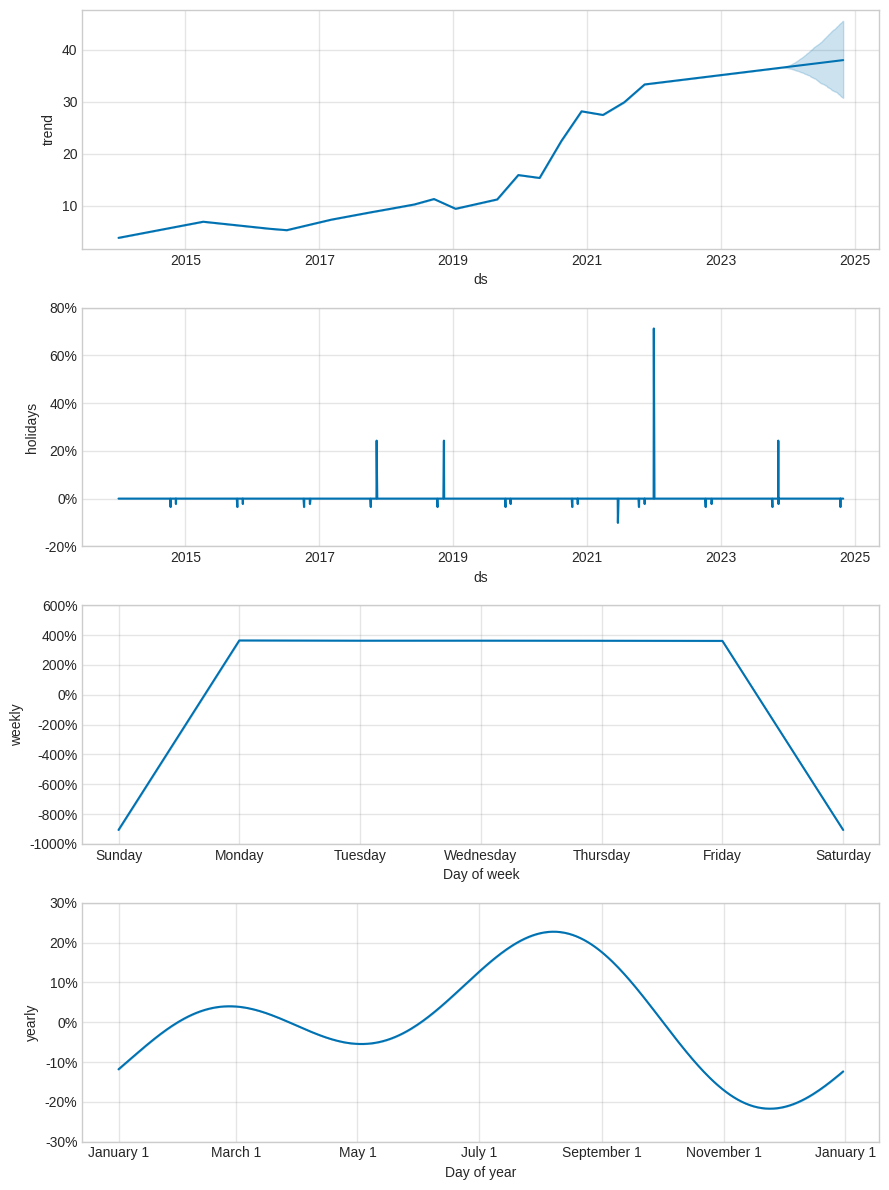

In [ ]:
forecast = m.predict(future)
fig = m.plot_components(forecast)

Validation

In [ ]:
df_cv = cross_validation(model, initial='730 days', period='180 days', horizon='365 days')
df_p = performance_metrics(df_cv)

print("Mean Absolute Error (MAE):", df_p['mae'].values[0])
print("Root Mean Squared Error (RMSE):", df_p['rmse'].values[0])

INFO:prophet:Making 14 forecasts with cutoffs between 2016-06-04 00:00:00 and 2022-10-31 00:00:00


  0%|          | 0/14 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp5ist70jx/eb5qmdxf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5ist70jx/k23jk1ib.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90377', 'data', 'file=/tmp/tmp5ist70jx/eb5qmdxf.json', 'init=/tmp/tmp5ist70jx/k23jk1ib.json', 'output', 'file=/tmp/tmp5ist70jx/prophet_model6tuofduq/prophet_model-20240107165046.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:50:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:50:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5ist70jx/b36ywyq_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5ist70jx/8f8kczg3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Mean Absolute Error (MAE): 8.651425074007529
Root Mean Squared Error (RMSE): 12.404260962988488


In [ ]:
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2016-06-06,24.902459,23.867006,25.936866,24.657499,2016-06-04
1,2016-06-07,24.792249,23.799411,25.727576,24.757500,2016-06-04
2,2016-06-08,24.736831,23.691580,25.785845,24.735001,2016-06-04
3,2016-06-09,24.638486,23.579237,25.706071,24.912500,2016-06-04
4,2016-06-10,24.552044,23.511655,25.536569,24.707500,2016-06-04


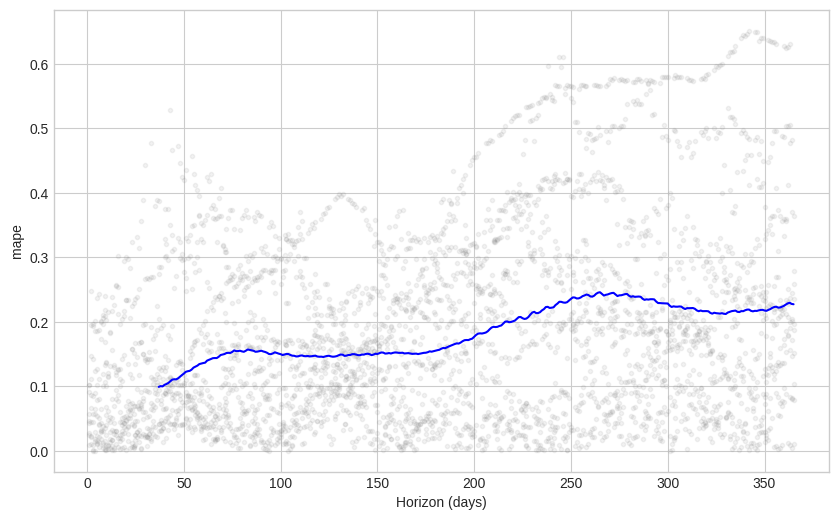

In [ ]:
fig = plot_cross_validation_metric(df_cv, metric='mape')

In [ ]:
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,37 days,153.865690,12.404261,8.651425,0.098789,0.067733,0.095427,0.352273
1,38 days,156.526705,12.511063,8.746924,0.099960,0.068754,0.096726,0.345455
2,39 days,157.127849,12.535065,8.741158,0.099554,0.068545,0.096372,0.343750
3,40 days,162.614023,12.752020,8.899552,0.101921,0.069213,0.098667,0.332386
4,41 days,166.927026,12.920024,9.010431,0.103257,0.071046,0.100110,0.325000
